<a href="https://colab.research.google.com/github/anupa-aa/DeepLearning.AI-Courses/blob/master/Compressed_Horses_or_Humans_with_ImageDataGenerator_(part2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training with ImageDataGenerator

Say we have sorted our training and validation data into directories in our filesystem. Instead of loading all the data onto the RAM at once (which in many cases won't be possible), we will use the ImageDataGenerator class.

Here are the advantages of using this :

<details><summary>Click for Advantages</summary>
<p>

- Data Augmentation: Data augmentation involves applying various transformations to the original images, such as rotations, flips, zooms, shifts, and brightness adjustments. This helps increase the diversity of your training data, reducing overfitting and improving the generalization of your model. ImageDataGenerator makes it easy to apply these augmentations on-the-fly while feeding data to the model.

- Real-time Augmentation: Instead of generating and storing augmented images beforehand, which could be memory-intensive, ImageDataGenerator generates augmented images on-the-fly during model training. This conserves memory and disk space.

- Ease of Use: ImageDataGenerator is easy to implement and seamlessly integrates with Keras models. You can define the augmentation options and preprocessing steps directly within the generator, simplifying the data pipeline setup.

- Efficient Batch Processing: The generator can generate batches of augmented images efficiently, ensuring that your model is trained on diverse data in each epoch. This is especially useful when working with large datasets that don't fit entirely in memory.

- Standardization and Normalization: ImageDataGenerator can handle standardization and normalization of pixel values for you, which is important for better convergence and training stability.

- Versatility: The ImageDataGenerator class is versatile and can be customized to suit your specific needs. You can control the type and magnitude of augmentations, and even create custom preprocessing functions.

- Reduced Overfitting: By introducing randomness through data augmentation, the model is less likely to memorize the training data and more likely to learn relevant features.

- Time Efficiency: Since data augmentation is performed on-the-fly, it saves time compared to generating augmented images separately before training.

- Avoiding Bias: Augmentation helps in reducing dataset bias and ensures that the model learns to generalize across various image variations.

</p>
</details>

## Getting our data

### Download the dataset as a zip file

In [1]:
# Training set
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip
# Validation set
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip


--2023-08-03 01:07:28--  https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.128.128, 74.125.143.128, 173.194.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.128.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘horse-or-human.zip’

horse-or-human.zip  100%[===================>] 142.65M  38.6MB/s    in 4.3s    

2023-08-03 01:07:33 (33.4 MB/s) - ‘horse-or-human.zip’ saved [149574867/149574867]

--2023-08-03 01:07:33--  https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.128.128, 74.125.143.128, 173.194.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.128.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (

### Unzip using Python's zipfile module

In [2]:
import zipfile

# Training
local_zip = './horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./horse-or-human')

# Validation
local_zip = './validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./validation-horse-or-human')

zip_ref.close()

The horse-or-human base directory contains the "horses" and "humans" subdirectory

Note we haven't labelled the images explicitly - we will use the ImageDataGenerator API which will automatically label images according to directory names and structure.

We could for example have a "training" directory which will contain the "horses" and "humans" subdirectory.

In [3]:
import os

### Lets now define these directories as variables

# Training directory
train_horse_dir = os.path.join("./horse-or-human/horses")
train_human_dir = os.path.join("./horse-or-human/humans")
# Validation directory
validation_horse_dir = os.path.join("./validation-horse-or-human/horses")
validation_human_dir = os.path.join("./validation-horse-or-human/humans")


### Store individual filenames as variables

train_horse_names = os.listdir(train_horse_dir)
train_human_names = os.listdir(train_human_dir)
validation_horse_names = os.listdir(validation_horse_dir)
validation_human_names = os.listdir(validation_human_dir)


# Find the size of our dataset
print(f"""
total training   horse images = {len(os.listdir(train_horse_dir))}
total training   human images = {len(os.listdir(train_human_dir))}
total validation horse images = {len(os.listdir(validation_horse_dir))}
total validation human images = {len(os.listdir(validation_human_dir))}
""")


total training   horse images = 500
total training   human images = 527
total validation horse images = 128
total validation human images = 128



### Have a peek at the data

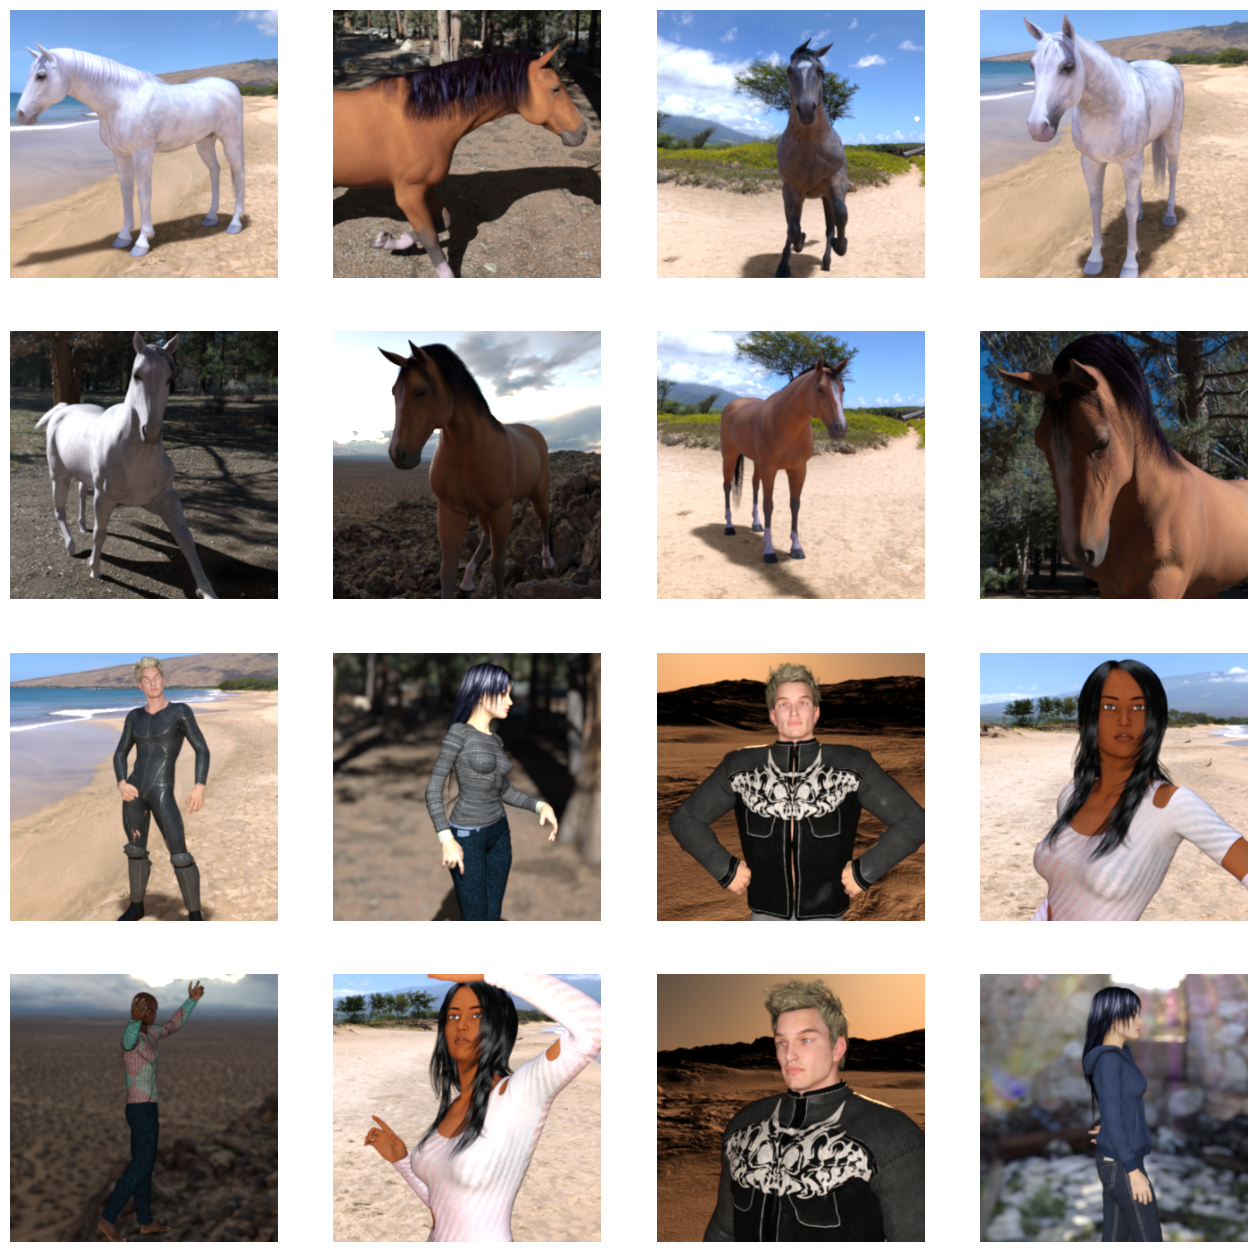

In [4]:
### Configure matplotlib settings
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# We want to display 4 images along x and 4 images along y
nrows = ncols = 4

# Index to iterate over images
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8

next_horse_pix = [
    os.path.join(train_horse_dir, fname) for fname in train_horse_names[
        pic_index-8:pic_index
    ]
]
next_human_pix = [
    os.path.join(train_human_dir, fname) for fname in train_human_names[
        pic_index-8:pic_index
    ]
]

### Plot the images
for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indicies start at one
  sp = plt.subplot(nrows, ncols, i+1)
  sp.axis("Off") # Dont show axis or gridlines

  img = mpimg.imread(img_path)
  plt.imshow(img)


### Show the plot
plt.show()


## Data Preprocessing

We neet to set up the data generators that will load in images from our directories and convert them to float32 tensors. They will then feed the images and the labels to the model.

We have one generator for the training set and one generator for the validation set.

For our problem, these generators should output batches of images size 300x300 and their labels (as a binary value 0 or 1).

We will need to normalise our pixel colour values (need to range from 0 to 1 instead of 0 to 255). We do this using the `keras.preprocessing.image.ImageDataGenerator` class with the `rescale` parameter. We can also instantiate generators of augmented image batches and labels via `.flow(data, labels)` or `.flow_from_directory(directory)`.

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescaling pixel values
train_datagen = ImageDataGenerator(rescale = 1/255)
validation_datagen = ImageDataGenerator(rescale = 1/255)

train_generator = train_datagen.flow_from_directory(
    "./horse-or-human",                 # Path to directory
    target_size = (150,150),            # Resizes images to 300x300
    batch_size = 128,                   # Sets batch size
    class_mode = "binary"               # We have 2 classes so binary labels
)

validation_generator = train_datagen.flow_from_directory(
    "./validation-horse-or-human",      # Path to directory
    target_size = (150,150),            # Resizes images to 300x300
    batch_size = 32,                    # Sets batch size
    class_mode = "binary"               # We have 2 classes so binary labels
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


## Initial model

In [6]:
from tensorflow import keras

model = keras.models.Sequential([

    # Remember input shape is (150,150,3) AS IT HAS 3 COLOUR CHANNELS!
    keras.layers.Conv2D(16, (3,3), activation="relu", input_shape=(150,150,3)),
    keras.layers.MaxPooling2D(2,2),

    # Batch normalization after the first convolutional layer
    #keras.layers.BatchNormalization(),

    # 2nd conv layer
    keras.layers.Conv2D(32, (3,3), activation="relu"),
    keras.layers.MaxPooling2D(2,2),

    # Batch normalization after the second convolutional layer
    #keras.layers.BatchNormalization(),

    # Dropout after the second convolutional layer
    keras.layers.Dropout(0.25),

    # 3rd conv layer
    keras.layers.Conv2D(64, (3,3), activation="relu"),
    keras.layers.MaxPooling2D(2,2),

    # Batch normalization after the third convolutional layer
    #keras.layers.BatchNormalization(),

    # Dropout after the third convolutional layer
    keras.layers.Dropout(0.25),

    #####
    # As we are using compressed images, we remove the 4th and 5th conv layers
    #####

    # 4th conv layer
    #keras.layers.Conv2D(64, (3,3), activation="relu"),
    #keras.layers.MaxPooling2D(2,2),

    # Batch normalization after the fourth convolutional layer
    #keras.layers.BatchNormalization(),

    # Dropout after the fourth convolutional layer
    #keras.layers.Dropout(0.25),

    # 5th conv layer
    #keras.layers.Conv2D(64, (3,3), activation="relu"),
    #keras.layers.MaxPooling2D(2,2),

    # Batch normalization after the fifth convolutional layer
    #keras.layers.BatchNormalization(),

    # Dropout after the fifth convolutional layer
    #keras.layers.Dropout(0.25),

    # Now we move into a more of a DNN phase, first by flattening
    # into a single array
    keras.layers.Flatten(),

    # Batch normalization after the flatten layer
    #keras.layers.BatchNormalization(),

    keras.layers.Dense(512, activation="relu"),

    # Batch normalization after the dense layer
    #keras.layers.BatchNormalization(),

    # Dropout after the dense layer
    keras.layers.Dropout(0.5),

    # Output layer
    keras.layers.Dense(1, activation="sigmoid")

])

In [7]:
# Get the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 36, 36, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        1

In [8]:
from tensorflow.keras.optimizers import RMSprop

# We are using RMSprop rather than sgd because it automatically does learning
# rate tuning (like Adam and Adagrad).

model.compile(
    loss="binary_crossentropy",
    optimizer=RMSprop(learning_rate=0.001),
    metrics=['accuracy']
)

## Defining a callback to stop training

In [9]:
class myCallback(keras.callbacks.Callback):

  def on_epoch_end(self, epoch, logs={}):
    if logs.get("val_accuracy") is not None and logs.get("val_accuracy") > 0.90:
      print("\nReached 90% val accuracy so stopped training")
      self.model.stop_training = True


## Training

In [10]:
history = model.fit(
    train_generator,

    # CALCULATING STEPS PER EPOCH
    # 1024 samples, with batch size 128, => 8 steps per epoch
    steps_per_epoch=8,

    # How many entire passes of the training data set do we want?
    epochs=15,

    # How much info do you want to display?
    verbose=1,

    validation_data=validation_generator,

    # CALCULATING VALIDATION STEPS
    # 256 samples in batches of 32 => 8 steps
    validation_steps=8,


    callbacks = [myCallback()]
)

Epoch 1/25
8/8 [==============================] - 19s 793ms/step - loss: 0.7837 - accuracy: 0.5417 - val_loss: 0.6871 - val_accuracy: 0.5000
Epoch 2/25
8/8 [==============================] - 7s 859ms/step - loss: 0.7967 - accuracy: 0.6340 - val_loss: 0.6986 - val_accuracy: 0.5000
Epoch 3/25
8/8 [==============================] - 7s 859ms/step - loss: 0.5430 - accuracy: 0.7230 - val_loss: 0.5428 - val_accuracy: 0.7617
Epoch 4/25
8/8 [==============================] - 6s 770ms/step - loss: 0.4363 - accuracy: 0.8009 - val_loss: 0.6707 - val_accuracy: 0.7422
Epoch 5/25
8/8 [==============================] - 7s 889ms/step - loss: 0.2058 - accuracy: 0.9277 - val_loss: 0.4726 - val_accuracy: 0.8438
Epoch 6/25
8/8 [==============================] - 7s 876ms/step - loss: 0.1253 - accuracy: 0.9533 - val_loss: 1.1909 - val_accuracy: 0.8047
Epoch 7/25
8/8 [==============================] - 7s 853ms/step - loss: 0.1127 - accuracy: 0.9531 - val_loss: 1.5268 - val_accuracy: 0.7344
Epoch 8/25
8/8 [===

## Making Predictions

In [13]:
### This code doesnt work on older Safari

import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = load_img(path, target_size=(150, 150))
  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])

  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")


Saving Untitled.jpeg to Untitled (1).jpeg
1/1 [==============================] - 0s 173ms/step
[0.08368032]
Untitled (1).jpeg is a horse


## Visualising Intermediate Representations

1/1 [==============================] - 0s 85ms/step


<ipython-input-14-2228b29b6039>:45: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


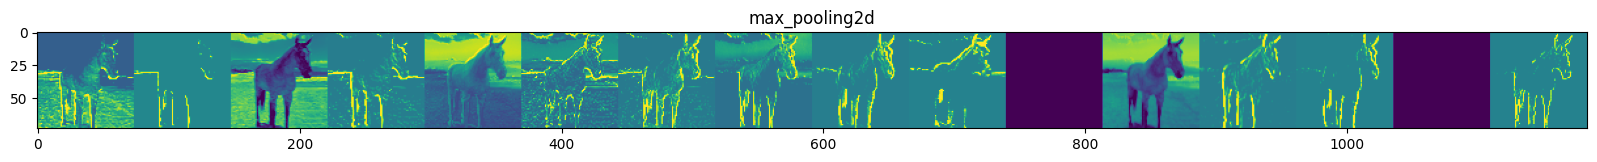

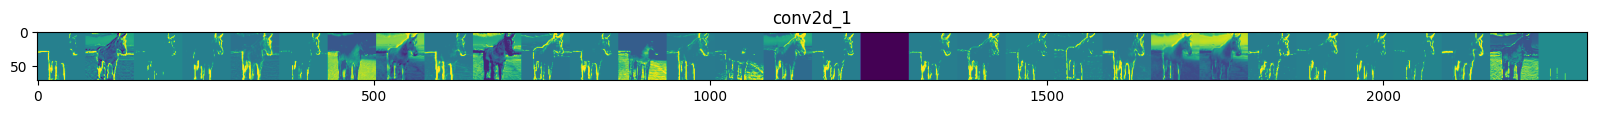

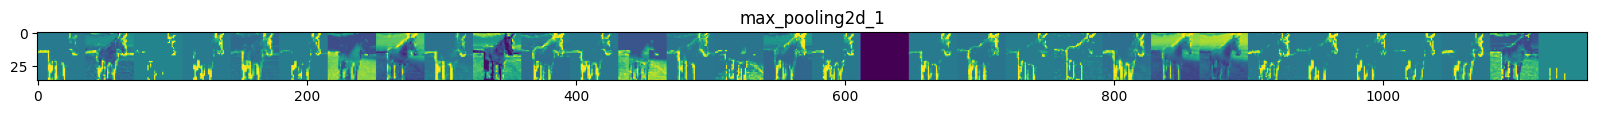

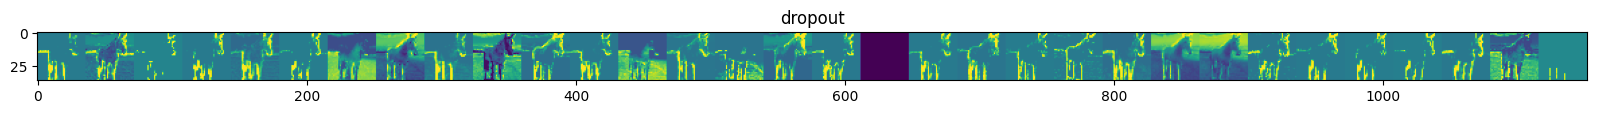

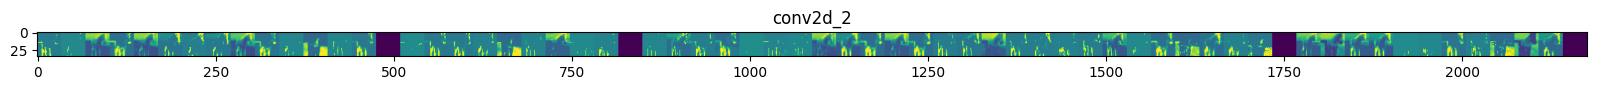

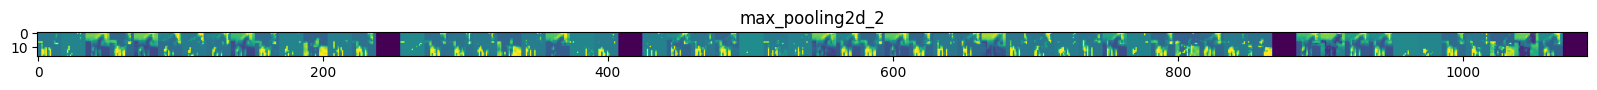

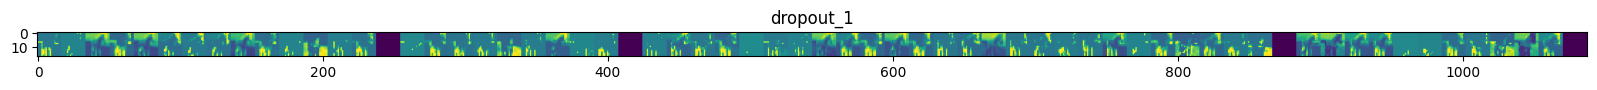

In [14]:
import numpy as np
import random
from tensorflow.keras.utils import img_to_array, load_img

# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (300, 300, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 300, 300, 3)

# Scale by 1/255
x /= 255

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of the plot
layer_names = [layer.name for layer in model.layers[1:]]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:

    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map

    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]

    # Tile the images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')

      # Tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x

    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to zero. This is called _representation sparsity_ and is a key feature of deep learning. These representations carry increasingly less information about the original pixels of the image, but increasingly refined information about the class of the image. You can think of a convnet (or a deep network in general) as an information distillation pipeline wherein each layer filters out the most useful features.

## Clean Up

In [ ]:
from google.colab import runtime
runtime.unassign()